In [1]:
# Import, Preprocess
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import gensim.downloader as api


# Base Model Structures
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU

# Model Modifications
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional

# Evaluation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import time

# Plotting
import matplotlib.pyplot as plt

C:\Users\nicol\miniconda3\envs\GPU\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Load the data 

In [3]:
X_train = pd.read_csv("../data/X_train.csv")
X_test = pd.read_csv("../data/X_test.csv")
y_train = pd.read_csv("../data/y_train.csv")
y_test = pd.read_csv("../data/y_test.csv")

X_train = X_train.text 
X_test = X_test.text
y_train = y_train.Dominance.astype('category')
y_test = y_test.Dominance.astype('category')

# Pre-processing

## Load word2Vec embeddings

In [4]:
word2vec_model = api.load("word2vec-google-news-300")

In [5]:
def preprocess(max_length, X_train, y_train, X_test, y_test): 
    # Preprocess the text data
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    X_train_pad = pad_sequences(X_train_sequences, maxlen=max_length)
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_train_lab = label_encoder.fit_transform(y_train)

    X_test_sequences = tokenizer.texts_to_sequences(X_test) 
    X_test_pad = pad_sequences(X_test_sequences, maxlen=max_length)
    
    y_test_lab = label_encoder.transform(y_test)

    # Create the embedding matrix
    embedding_dim = 300  # Dimension of Word2Vec vectors
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    # Populate the embedding matrix with Word2Vec vectors
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = word2vec_model[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            # If the word is not in the Word2Vec vocabulary, leave it as zero vector
            continue

    return X_train_pad, y_train_lab, X_test_pad, y_test_lab, label_encoder, vocab_size, embedding_dim, embedding_matrix

## Test a model

In [6]:
def runModel(model_name, model, X_train, y_train, X_test, y_test, label_encoder, epochs=20, batch_size=256): 
    tf.random.set_seed(2319)
    start_time = time.time()
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

    end_time = time.time()

    total_time = (end_time - start_time)
    
    y_pred = model.predict(X_test)
    
    y_pred = np.argmax(y_pred, axis=1)
    
    p,r,f,s = precision_recall_fscore_support(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    dominance_results = pd.DataFrame({
                           'Precision':p,
                           'Recall':r, 
                           'F1': f, 
                           "Support": s})
    
    macro_scores = dominance_results.loc[:, ["Precision", "Recall", "F1"]].agg('mean')
    
    results = pd.DataFrame({'Model': [model_name], 
                           'Accuracy': [acc], 
                            'Precision': [macro_scores.Precision], 
                            'Recall': [macro_scores.Recall], 
                            'F1': [macro_scores.F1],
                            'Training_Time': [total_time]
                           })
    return results, history


def plot_loss(model_hist): 
    loss = model_hist.history['loss']
    val_loss = model_hist.history['val_loss']
    
    # Plot the loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(loss, label='Training Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='o')
    plt.title('Model Loss Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

## Build and Run Models 

# GRU Dropout - 10 words

In [7]:
max_len = 10
X_train_pad, y_train_lab, X_test_pad, y_test_lab, label_encoder, vocab_size, embedding_dim, embedding_matrix = preprocess(max_len, X_train, y_train, X_test, y_test)

Epoch 1/20
83/83 [==============================] - 4s 7ms/step - loss: 2.6891 - accuracy: 0.2501 - val_loss: 2.3118 - val_accuracy: 0.3667
Epoch 2/20
83/83 [==============================] - 0s 4ms/step - loss: 2.1050 - accuracy: 0.4180 - val_loss: 1.9032 - val_accuracy: 0.4766
Epoch 3/20
83/83 [==============================] - 0s 4ms/step - loss: 1.8224 - accuracy: 0.4957 - val_loss: 1.7424 - val_accuracy: 0.5186
Epoch 4/20
83/83 [==============================] - 0s 4ms/step - loss: 1.7037 - accuracy: 0.5241 - val_loss: 1.6748 - val_accuracy: 0.5321
Epoch 5/20
83/83 [==============================] - 0s 4ms/step - loss: 1.6403 - accuracy: 0.5365 - val_loss: 1.6407 - val_accuracy: 0.5368
Epoch 6/20
83/83 [==============================] - 0s 4ms/step - loss: 1.5933 - accuracy: 0.5460 - val_loss: 1.6061 - val_accuracy: 0.5473
Epoch 7/20
83/83 [==============================] - 0s 4ms/step - loss: 1.5649 - accuracy: 0.5548 - val_loss: 1.5878 - val_accuracy: 0.5511
Epoch 8/20
83/83 [==

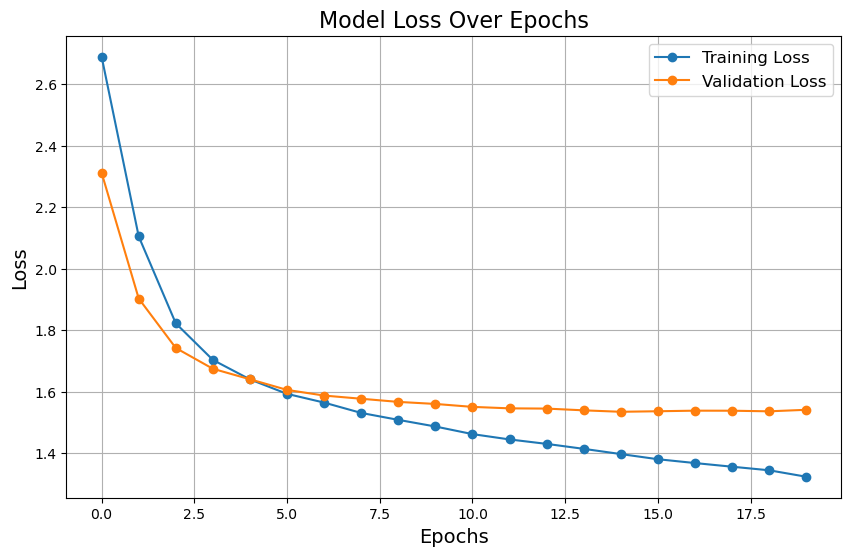

In [8]:
gru_10 = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
gru_10.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

gru_10.add(Dropout(0.2))
gru_10.add(GRU(100))
gru_10.add(Dropout(0.2))

gru_10.add(Dense(24, activation='softmax'))
gru_10.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

gru_10_results, gru_10_history = runModel(
    model_name="10 Words", 
    model=gru_10, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(gru_10_history)

## GRU Dropout - 15 words

In [9]:
max_len = 15
X_train_pad, y_train_lab, X_test_pad, y_test_lab, label_encoder, vocab_size, embedding_dim, embedding_matrix = preprocess(max_len, X_train, y_train, X_test, y_test)

Epoch 1/20
83/83 [==============================] - 2s 9ms/step - loss: 2.6681 - accuracy: 0.2606 - val_loss: 2.2416 - val_accuracy: 0.3889
Epoch 2/20
83/83 [==============================] - 0s 5ms/step - loss: 1.9958 - accuracy: 0.4464 - val_loss: 1.7409 - val_accuracy: 0.5180
Epoch 3/20
83/83 [==============================] - 0s 5ms/step - loss: 1.6600 - accuracy: 0.5370 - val_loss: 1.5573 - val_accuracy: 0.5596
Epoch 4/20
83/83 [==============================] - 0s 5ms/step - loss: 1.5169 - accuracy: 0.5687 - val_loss: 1.4759 - val_accuracy: 0.5801
Epoch 5/20
83/83 [==============================] - 0s 5ms/step - loss: 1.4474 - accuracy: 0.5865 - val_loss: 1.4349 - val_accuracy: 0.5902
Epoch 6/20
83/83 [==============================] - 0s 5ms/step - loss: 1.3944 - accuracy: 0.6003 - val_loss: 1.3999 - val_accuracy: 0.5987
Epoch 7/20
83/83 [==============================] - 0s 5ms/step - loss: 1.3618 - accuracy: 0.6058 - val_loss: 1.3811 - val_accuracy: 0.6069
Epoch 8/20
83/83 [==

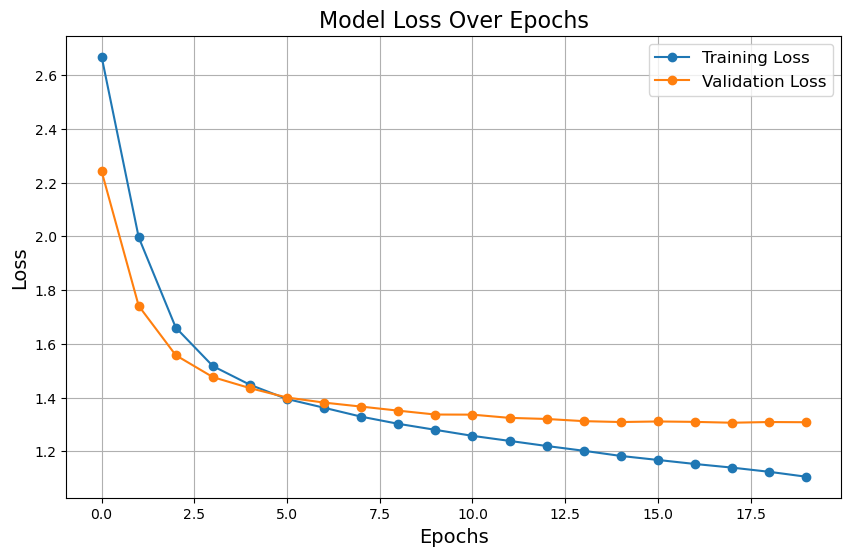

In [10]:
gru_15 = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
gru_15.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

gru_15.add(Dropout(0.2))
gru_15.add(GRU(100))
gru_15.add(Dropout(0.2))

gru_15.add(Dense(24, activation='softmax'))
gru_15.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

gru_15_results, gru_15_history = runModel(
    model_name="15 Words", 
    model=gru_15, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(gru_15_history)

# GRU Dropout - 20 words

In [11]:
max_len = 20
X_train_pad, y_train_lab, X_test_pad, y_test_lab, label_encoder, vocab_size, embedding_dim, embedding_matrix = preprocess(max_len, X_train, y_train, X_test, y_test)

Epoch 1/20
83/83 [==============================] - 2s 11ms/step - loss: 2.6722 - accuracy: 0.2558 - val_loss: 2.2398 - val_accuracy: 0.3963
Epoch 2/20
83/83 [==============================] - 0s 6ms/step - loss: 1.9224 - accuracy: 0.4665 - val_loss: 1.6610 - val_accuracy: 0.5321
Epoch 3/20
83/83 [==============================] - 0s 5ms/step - loss: 1.5575 - accuracy: 0.5625 - val_loss: 1.4683 - val_accuracy: 0.5864
Epoch 4/20
83/83 [==============================] - 0s 5ms/step - loss: 1.4062 - accuracy: 0.6018 - val_loss: 1.3780 - val_accuracy: 0.6073
Epoch 5/20
83/83 [==============================] - 0s 5ms/step - loss: 1.3376 - accuracy: 0.6161 - val_loss: 1.3310 - val_accuracy: 0.6185
Epoch 6/20
83/83 [==============================] - 0s 5ms/step - loss: 1.2768 - accuracy: 0.6312 - val_loss: 1.2946 - val_accuracy: 0.6255
Epoch 7/20
83/83 [==============================] - 0s 5ms/step - loss: 1.2439 - accuracy: 0.6407 - val_loss: 1.2655 - val_accuracy: 0.6331
Epoch 8/20
83/83 [=

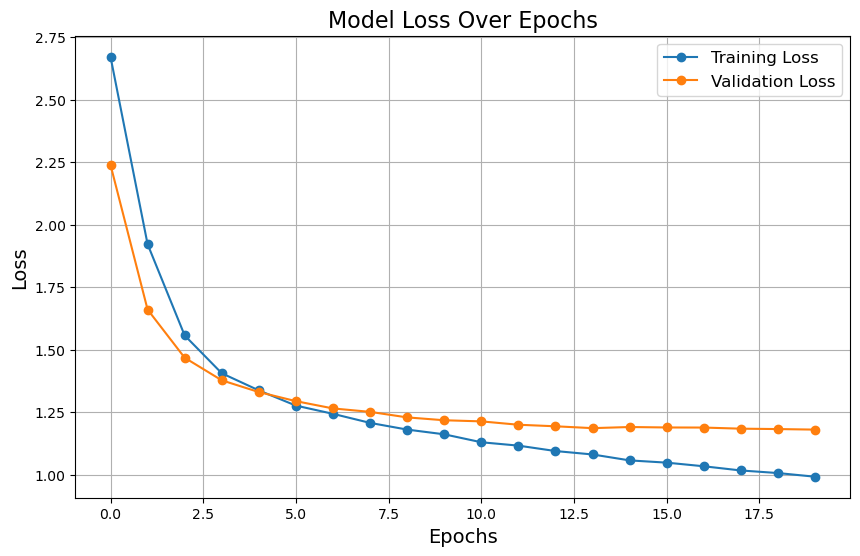

In [12]:
gru_20 = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
gru_20.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

gru_20.add(Dropout(0.2))
gru_20.add(GRU(100))
gru_20.add(Dropout(0.2))

gru_20.add(Dense(24, activation='softmax'))
gru_20.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

gru_20_results, gru_20_history = runModel(
    model_name="20 Words", 
    model=gru_20, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(gru_20_history)

# GRU Dropout - 25 words 

In [13]:
max_len = 25
X_train_pad, y_train_lab, X_test_pad, y_test_lab, label_encoder, vocab_size, embedding_dim, embedding_matrix = preprocess(max_len, X_train, y_train, X_test, y_test)

Epoch 1/20
83/83 [==============================] - 2s 9ms/step - loss: 2.6485 - accuracy: 0.2654 - val_loss: 2.1959 - val_accuracy: 0.3895
Epoch 2/20
83/83 [==============================] - 0s 5ms/step - loss: 1.9617 - accuracy: 0.4600 - val_loss: 1.6765 - val_accuracy: 0.5378
Epoch 3/20
83/83 [==============================] - 0s 6ms/step - loss: 1.5413 - accuracy: 0.5741 - val_loss: 1.4229 - val_accuracy: 0.5997
Epoch 4/20
83/83 [==============================] - 0s 6ms/step - loss: 1.3571 - accuracy: 0.6161 - val_loss: 1.3124 - val_accuracy: 0.6250
Epoch 5/20
83/83 [==============================] - 0s 6ms/step - loss: 1.2728 - accuracy: 0.6360 - val_loss: 1.2603 - val_accuracy: 0.6396
Epoch 6/20
83/83 [==============================] - 0s 6ms/step - loss: 1.2127 - accuracy: 0.6468 - val_loss: 1.2216 - val_accuracy: 0.6468
Epoch 7/20
83/83 [==============================] - 0s 5ms/step - loss: 1.1670 - accuracy: 0.6595 - val_loss: 1.1896 - val_accuracy: 0.6500
Epoch 8/20
83/83 [==

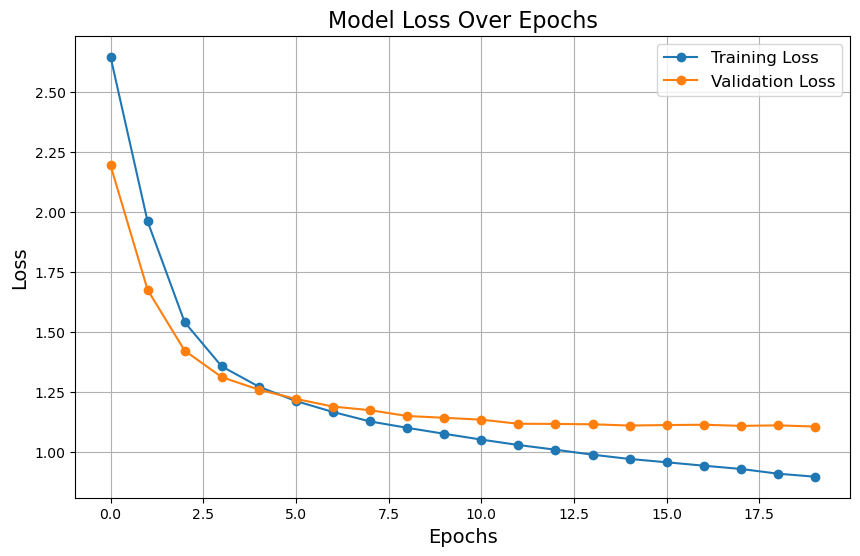

In [14]:
gru_25 = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
gru_25.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

gru_25.add(Dropout(0.2))
gru_25.add(GRU(100))
gru_25.add(Dropout(0.2))

gru_25.add(Dense(24, activation='softmax'))
gru_25.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

gru_25_results, gru_25_history = runModel(
    model_name="25 Words", 
    model=gru_25, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(gru_25_history)

# GRU Dropout - 30 words 

In [15]:
max_len = 30
X_train_pad, y_train_lab, X_test_pad, y_test_lab, label_encoder, vocab_size, embedding_dim, embedding_matrix = preprocess(max_len, X_train, y_train, X_test, y_test)

Epoch 1/20
83/83 [==============================] - 1s 8ms/step - loss: 2.6656 - accuracy: 0.2606 - val_loss: 2.2433 - val_accuracy: 0.3904
Epoch 2/20
83/83 [==============================] - 0s 6ms/step - loss: 1.9040 - accuracy: 0.4739 - val_loss: 1.5848 - val_accuracy: 0.5625
Epoch 3/20
83/83 [==============================] - 0s 6ms/step - loss: 1.4704 - accuracy: 0.5902 - val_loss: 1.3546 - val_accuracy: 0.6156
Epoch 4/20
83/83 [==============================] - 0s 6ms/step - loss: 1.3015 - accuracy: 0.6273 - val_loss: 1.2497 - val_accuracy: 0.6350
Epoch 5/20
83/83 [==============================] - 0s 6ms/step - loss: 1.2173 - accuracy: 0.6459 - val_loss: 1.2001 - val_accuracy: 0.6504
Epoch 6/20
83/83 [==============================] - 0s 5ms/step - loss: 1.1555 - accuracy: 0.6617 - val_loss: 1.1581 - val_accuracy: 0.6645
Epoch 7/20
83/83 [==============================] - 0s 5ms/step - loss: 1.1121 - accuracy: 0.6725 - val_loss: 1.1248 - val_accuracy: 0.6717
Epoch 8/20
83/83 [==

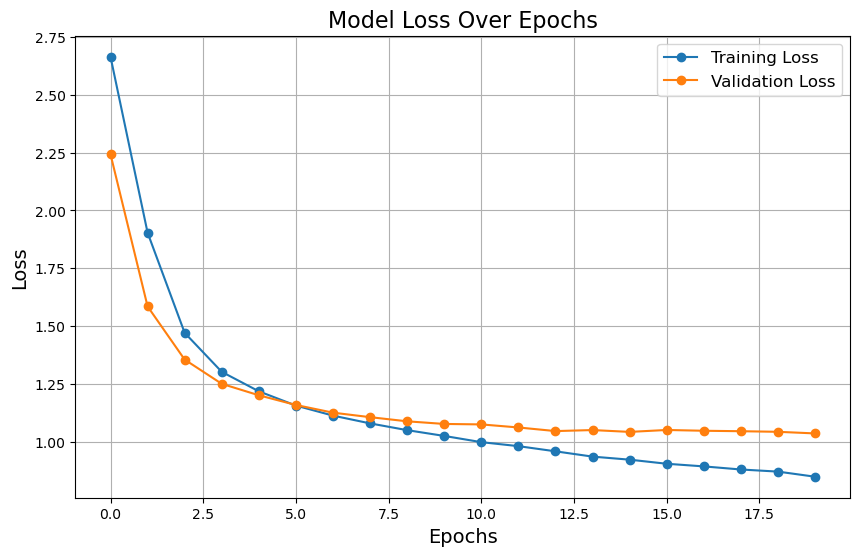

In [16]:
gru_30 = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
gru_30.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

gru_30.add(Dropout(0.2))
gru_30.add(GRU(100))
gru_30.add(Dropout(0.2))

gru_30.add(Dense(24, activation='softmax'))
gru_30.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

gru_30_results, gru_30_history = runModel(
    model_name="30 Words", 
    model=gru_30, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(gru_30_history)

# GRU Dropout 50 words 

In [17]:
max_len = 50
X_train_pad, y_train_lab, X_test_pad, y_test_lab, label_encoder, vocab_size, embedding_dim, embedding_matrix = preprocess(max_len, X_train, y_train, X_test, y_test)

Epoch 1/20
83/83 [==============================] - 2s 12ms/step - loss: 2.6506 - accuracy: 0.2664 - val_loss: 2.1964 - val_accuracy: 0.3927
Epoch 2/20
83/83 [==============================] - 1s 8ms/step - loss: 1.8380 - accuracy: 0.4914 - val_loss: 1.5271 - val_accuracy: 0.5779
Epoch 3/20
83/83 [==============================] - 1s 7ms/step - loss: 1.4072 - accuracy: 0.6047 - val_loss: 1.3068 - val_accuracy: 0.6341
Epoch 4/20
83/83 [==============================] - 1s 8ms/step - loss: 1.2283 - accuracy: 0.6477 - val_loss: 1.1801 - val_accuracy: 0.6624
Epoch 5/20
83/83 [==============================] - 1s 7ms/step - loss: 1.1334 - accuracy: 0.6664 - val_loss: 1.1104 - val_accuracy: 0.6758
Epoch 6/20
83/83 [==============================] - 1s 7ms/step - loss: 1.0765 - accuracy: 0.6834 - val_loss: 1.0743 - val_accuracy: 0.6893
Epoch 7/20
83/83 [==============================] - 1s 7ms/step - loss: 1.0296 - accuracy: 0.6957 - val_loss: 1.0465 - val_accuracy: 0.6878
Epoch 8/20
83/83 [=

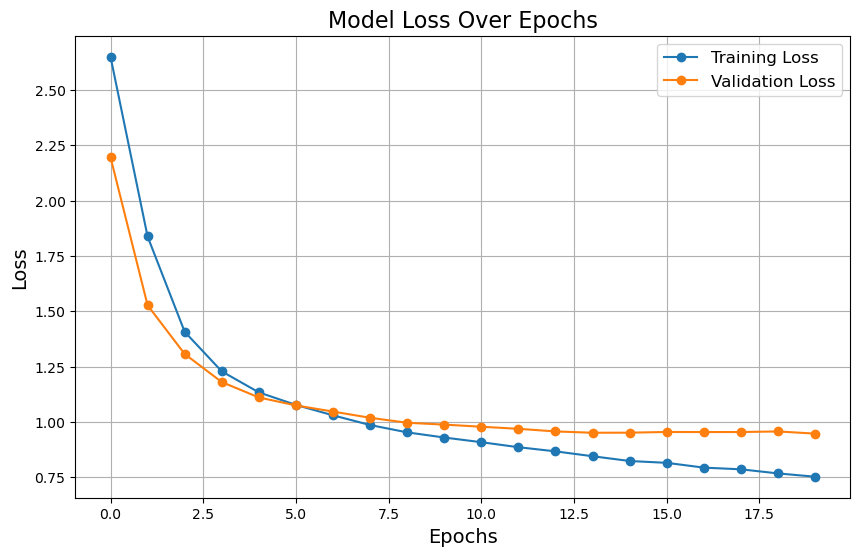

In [18]:
gru_50 = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
gru_50.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

gru_50.add(Dropout(0.2))
gru_50.add(GRU(100))
gru_50.add(Dropout(0.2))

gru_50.add(Dense(24, activation='softmax'))
gru_50.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

gru_50_results, gru_50_history = runModel(
    model_name="50 Words", 
    model=gru_50, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(gru_50_history)

# GRU Dropout - 100 words

In [19]:
max_len = 100
X_train_pad, y_train_lab, X_test_pad, y_test_lab, label_encoder, vocab_size, embedding_dim, embedding_matrix = preprocess(max_len, X_train, y_train, X_test, y_test)

Epoch 1/20
83/83 [==============================] - 2s 17ms/step - loss: 2.6679 - accuracy: 0.2582 - val_loss: 2.2515 - val_accuracy: 0.3728
Epoch 2/20
83/83 [==============================] - 1s 13ms/step - loss: 1.8534 - accuracy: 0.4842 - val_loss: 1.4913 - val_accuracy: 0.5855
Epoch 3/20
83/83 [==============================] - 1s 12ms/step - loss: 1.3719 - accuracy: 0.6144 - val_loss: 1.2466 - val_accuracy: 0.6466
Epoch 4/20
83/83 [==============================] - 1s 13ms/step - loss: 1.1950 - accuracy: 0.6589 - val_loss: 1.1348 - val_accuracy: 0.6713
Epoch 5/20
83/83 [==============================] - 1s 12ms/step - loss: 1.1007 - accuracy: 0.6765 - val_loss: 1.0654 - val_accuracy: 0.6876
Epoch 6/20
83/83 [==============================] - 1s 13ms/step - loss: 1.0411 - accuracy: 0.6931 - val_loss: 1.0280 - val_accuracy: 0.6954
Epoch 7/20
83/83 [==============================] - 1s 12ms/step - loss: 0.9927 - accuracy: 0.7033 - val_loss: 0.9933 - val_accuracy: 0.7036
Epoch 8/20
83

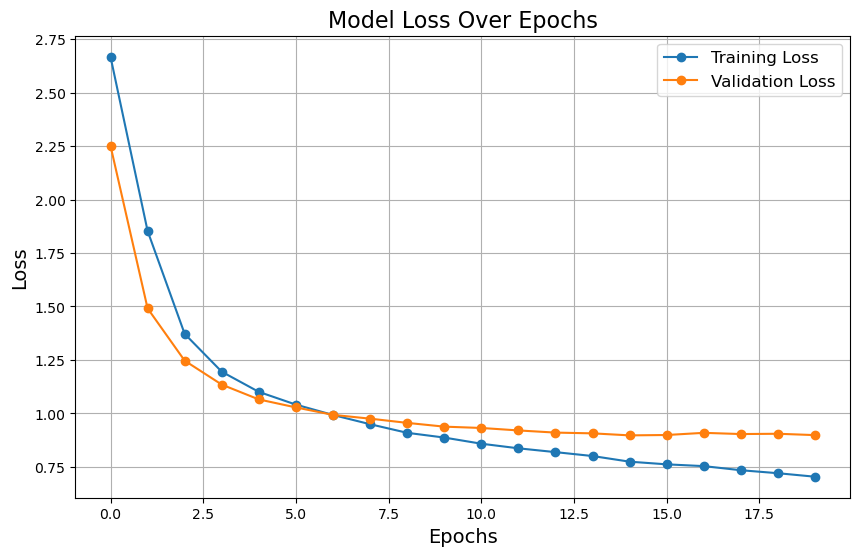

In [20]:
gru_100 = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
gru_100.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

gru_100.add(Dropout(0.2))
gru_100.add(GRU(100))
gru_100.add(Dropout(0.2))

gru_100.add(Dense(24, activation='softmax'))
gru_100.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

gru_100_results, gru_100_history = runModel(
    model_name="100 Words", 
    model=gru_100, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(gru_100_history)

# GRU Dropout - 150 Words

In [21]:
max_len = 150
X_train_pad, y_train_lab, X_test_pad, y_test_lab, label_encoder, vocab_size, embedding_dim, embedding_matrix = preprocess(max_len, X_train, y_train, X_test, y_test)

Epoch 1/20
83/83 [==============================] - 2s 20ms/step - loss: 2.6720 - accuracy: 0.2550 - val_loss: 2.1778 - val_accuracy: 0.3978
Epoch 2/20
83/83 [==============================] - 1s 17ms/step - loss: 1.8744 - accuracy: 0.4764 - val_loss: 1.5295 - val_accuracy: 0.5777
Epoch 3/20
83/83 [==============================] - 1s 16ms/step - loss: 1.4053 - accuracy: 0.6072 - val_loss: 1.2589 - val_accuracy: 0.6434
Epoch 4/20
83/83 [==============================] - 1s 16ms/step - loss: 1.2095 - accuracy: 0.6524 - val_loss: 1.1389 - val_accuracy: 0.6682
Epoch 5/20
83/83 [==============================] - 1s 16ms/step - loss: 1.1103 - accuracy: 0.6767 - val_loss: 1.0732 - val_accuracy: 0.6829
Epoch 6/20
83/83 [==============================] - 1s 16ms/step - loss: 1.0371 - accuracy: 0.6921 - val_loss: 1.0231 - val_accuracy: 0.6935
Epoch 7/20
83/83 [==============================] - 1s 16ms/step - loss: 0.9831 - accuracy: 0.7047 - val_loss: 0.9941 - val_accuracy: 0.6990
Epoch 8/20
83

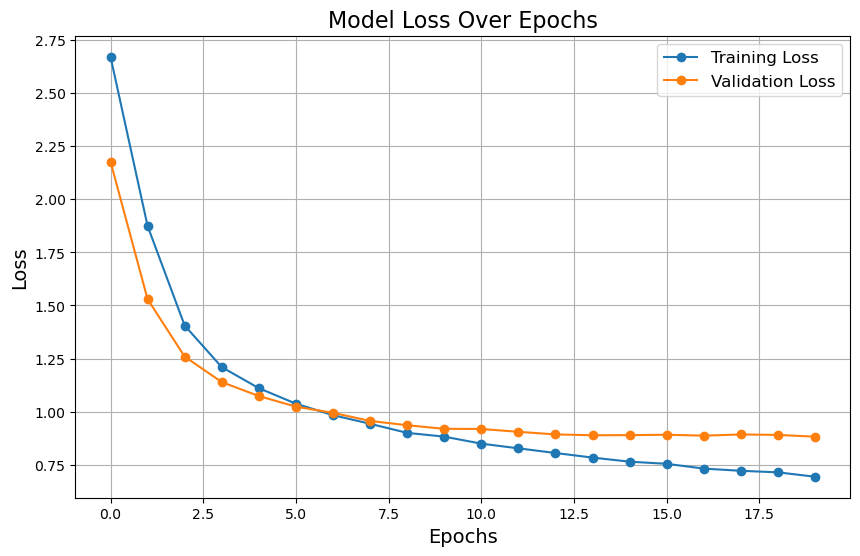

In [22]:
gru_150 = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
gru_150.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

gru_150.add(Dropout(0.2))
gru_150.add(GRU(100))
gru_150.add(Dropout(0.2))

gru_150.add(Dense(24, activation='softmax'))
gru_150.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

gru_150_results, gru_150_history = runModel(
    model_name="150 Words", 
    model=gru_150, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(gru_150_history)

# GRU Dropout - 200 Words

In [23]:
max_len = 200
X_train_pad, y_train_lab, X_test_pad, y_test_lab, label_encoder, vocab_size, embedding_dim, embedding_matrix = preprocess(max_len, X_train, y_train, X_test, y_test)

Epoch 1/20
83/83 [==============================] - 3s 25ms/step - loss: 2.6846 - accuracy: 0.2521 - val_loss: 2.2366 - val_accuracy: 0.3973
Epoch 2/20
83/83 [==============================] - 2s 22ms/step - loss: 1.8751 - accuracy: 0.4829 - val_loss: 1.5027 - val_accuracy: 0.5870
Epoch 3/20
83/83 [==============================] - 2s 21ms/step - loss: 1.3568 - accuracy: 0.6186 - val_loss: 1.2227 - val_accuracy: 0.6561
Epoch 4/20
83/83 [==============================] - 2s 21ms/step - loss: 1.1696 - accuracy: 0.6633 - val_loss: 1.1057 - val_accuracy: 0.6762
Epoch 5/20
83/83 [==============================] - 2s 20ms/step - loss: 1.0761 - accuracy: 0.6843 - val_loss: 1.0559 - val_accuracy: 0.6912
Epoch 6/20
83/83 [==============================] - 2s 20ms/step - loss: 1.0189 - accuracy: 0.6983 - val_loss: 1.0120 - val_accuracy: 0.6992
Epoch 7/20
83/83 [==============================] - 2s 20ms/step - loss: 0.9674 - accuracy: 0.7075 - val_loss: 0.9833 - val_accuracy: 0.7053
Epoch 8/20
83

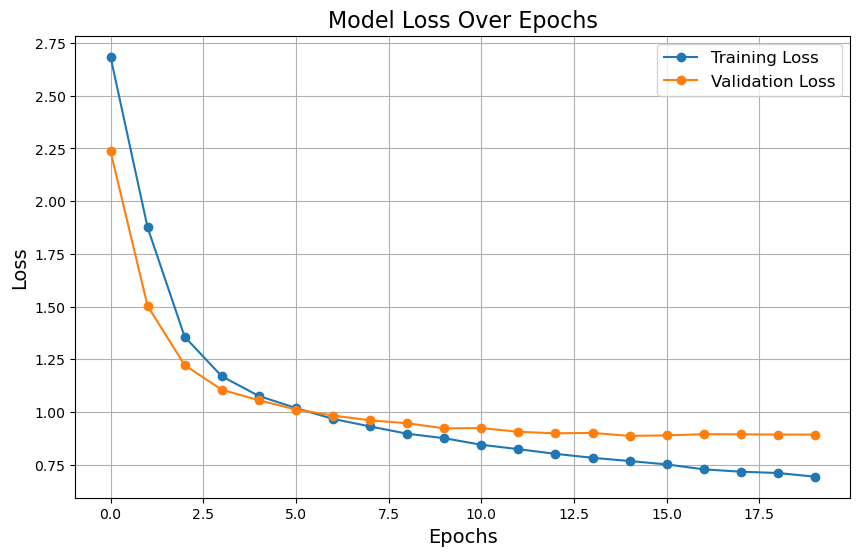

In [24]:
gru_200 = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
gru_200.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

gru_200.add(Dropout(0.2))
gru_200.add(GRU(100))
gru_200.add(Dropout(0.2))

gru_200.add(Dense(24, activation='softmax'))
gru_200.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

gru_200_results, gru_200_history = runModel(
    model_name="200 Words", 
    model=gru_200, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(gru_200_history)

# Summary

In [33]:
summary = pd.concat([gru_10_results, 
                    gru_15_results, 
                    gru_20_results, 
                    gru_25_results, 
                    gru_30_results, 
                    gru_50_results, 
                    gru_100_results,
                    gru_150_results, 
                    gru_200_results])
lengths = [10, 15, 20, 25, 30, 50, 100, 150, 200]
summary['Comment Length'] = lengths
summary.sort_values('F1', ascending=False)

,Model,Accuracy,Precision,Recall,F1,Training_Time,Comment Length
0,150 Words,0.736612,0.730434,0.702818,0.714587,27.835107,150
0,200 Words,0.734713,0.731350,0.698371,0.711960,35.478779,200
0,100 Words,0.732434,0.725161,0.699651,0.710073,21.656034,100
0,50 Words,0.721041,0.717878,0.686904,0.698926,13.552532,50
0,30 Words,0.694265,0.683683,0.656659,0.667983,10.583742,30
0,25 Words,0.675085,0.669746,0.642446,0.653554,10.182254,25
0,20 Words,0.661033,0.674304,0.628242,0.646690,9.389002,20
0,15 Words,0.627421,0.651001,0.591803,0.614378,9.114275,15
0,10 Words,0.567983,0.585061,0.527667,0.548459,10.814928,10


Text(0.5, 1.0, 'Macro F1 Score by Comment Length')

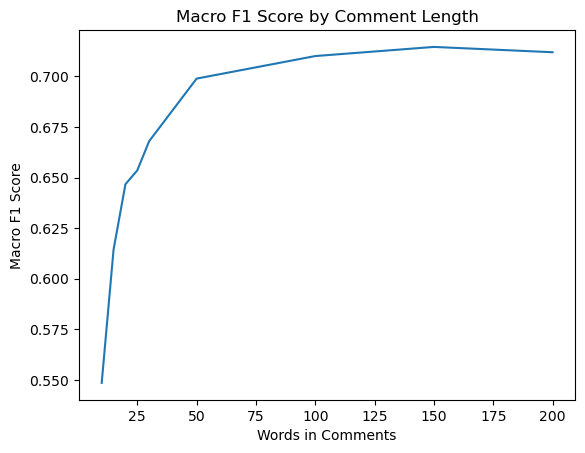

In [35]:
plt.plot(summary['Comment Length'], summary['F1'])
plt.xlabel("Words in Comments")
plt.ylabel("Macro F1 Score")
plt.title("Macro F1 Score by Comment Length")